In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from math import log
import math
import cv2
from tqdm import tqdm
import pandas as pd
from math import ceil
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [67]:
def import_dataset(dataset_path, label_names):
    dataset = []
    labels = []
    limit=100
    
    for label_index, label_name in enumerate(label_names):
        label_path = os.path.join(dataset_path, label_name)
        image_files = os.listdir(label_path)[:limit]
        
        for image_file in image_files:
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            
            if image is not None:
                dataset.append(image)
                labels.append(label_index)
   
    return dataset, labels

dataset_folder = 'PotatoPlants'
label_names = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
dataset, labels = import_dataset(dataset_folder, label_names)

In [75]:
dataset_dir = "PotatoPlants/"
images = []
labels = []
names = []

total_images = sum(len(files) for _, _, files in os.walk(dataset_dir))

with tqdm(total=total_images, desc="Grayscaling images") as pbar:
    for sub_folder in os.listdir(dataset_dir):
        sub_folder_path = os.path.join(dataset_dir, sub_folder)
        if os.path.isdir(sub_folder_path):
            sub_folder_files = os.listdir(sub_folder_path)
            for i, filename in enumerate(sub_folder_files):
                img = cv2.imread(file_path)
                file_path = os.path.join(sub_folder_path, filename)
                if sub_folder == 'Potato___Early_blight':
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(gray)
                    labels.append(sub_folder)
                    names.append(filename)
                elif sub_folder == 'Potato___Late_blight':
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(gray)
                    labels.append(sub_folder)
                    names.append(filename)
                else:
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(gray)
                    labels.append(sub_folder)
                    names.append(filename)

                pbar.update(1)

names = np.array(names)

Grayscaling images: 100%|██████████| 300/300 [00:00<00:00, 476.98it/s]


In [56]:
def transpose(matrix):
    matrix_transpose = []
    row,col = matrix.shape
    for i in range(row):
        mRow = []
        for j in range(col):
            mRow.append(matrix[j][i])
        matrix_transpose.append(mRow)
    return matrix_transpose

def dataSum(image):
    result = 0
    for i in range (len(image)):
        for j in range(len(image)):
            result+=image[i,j]
    return result

def normalization(image):
    row, col = image.shape
    n = dataSum(image)
    for i in range(row):
        for j in range(col):
            image[i,j]/=n
    return image

def cooccurance (image, dimention, degree):
    row, col = image.shape
    matrixCo = np.zeros([dimention+1,dimention+1])
    if(degree == 0):
        for i in range(row):
            for j in range(col):
                if(j+1 < col):
                    matrixCo[image[i,j], image[i,j+1]] += 1
    elif (degree == 45):
        for i in range(row):
            for j in range(col):
                if(i-1 >= 0 and j+1 < col):
                    matrixCo[image[i,j], image[i-1,j+1]] += 1
    elif (degree == 90):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j]] += 1
    elif (degree == 135):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j+1]] += 1
    trans = transpose(matrixCo)
    sumMatrix = matrixCo+trans
    glcm = normalization(sumMatrix)
    return glcm

In [15]:
def mean(image):
    meanX=meanY= 0
    for i in range (len(image)):
        for j in range(len(image)):
            meanX += i * image[i,j]
            meanY += j * image[i,j]
    return meanX, meanY

def tao(image):
    taoX=taoY=0
    meanX,meanY= mean(image)
    for i in range (len(image)):
        for j in range(len(image)):
            taoX += pow((i-meanX),2)*image[i,j]
            taoY += pow((j-meanY),2)*image[i,j]
    return taoX, taoY

def extraction(image):
    energy=homogenity=entropy=contrast=disimilarity=correlation=ASM=0
    meanX, meanY = mean(image)
    taoX, taoY = tao(image)
    for i in range (len(image)):
        for j in range (len(image)):
            contrast += image[i,j]*pow((i-j),2)
            disimilarity += image[i,j]*abs(i-j)
            homogenity += image[i,j]/1+abs(i-j)
            if image[i,j] > 0:
                entropy += -(image[i,j] * log(image[i,j]))
            ASM += pow(image[i,j],2)
            correlation+=((i-meanX)*(j-meanY)*image[i,j])/pow((taoX*taoY),1/2)
    energy = pow(ASM, 1/2)
    return contrast,disimilarity,homogenity,entropy,ASM,energy,correlation

In [76]:
def getGLCM(images):
    glcmImage = []
    for i in tqdm(range(len(images)), desc="Calculating GLCM"):
        glcm = []
        max_val = images[i].max()
        glcm.append(cooccurance(images[i], max_val, 0))
        glcm.append(cooccurance(images[i], max_val, 45))
        glcm.append(cooccurance(images[i], max_val, 90))
        glcm.append(cooccurance(images[i], max_val, 135))
        glcmImage.append(glcm)
    return glcmImage

glcm_images = getGLCM(images)

csv = []
for index in tqdm(range(len(glcm_images)), desc="Extracting features"):
    i = glcm_images[index]
    extract = []
    extract.append(names[index])
    extract.append(labels[index])
    for img in i:
        contrast, disimilarity, homogenity, entropy, ASM, energy, correlation = extraction(img)
        extract.append(contrast)
        extract.append(disimilarity)
        extract.append(homogenity)
        extract.append(entropy)
        extract.append(ASM)
        extract.append(energy)
        extract.append(correlation)
    csv.append(extract)


Extracting features: 100%|██████████| 300/300 [06:31<00:00,  1.31s/it]


In [77]:
headerKentang = ['Name','Label','Contrast0','Dissimilarity0','Homogenity0','Entropy0','ASM0','Energy0','Correlation0'
           ,'Contrast45','Dissimilarity45','Homogenity45','Entropy45','ASM45','Energy45','Correlation45'
           ,'Contrast90','Dissimilarity90','Homogenity90','Entropy90','ASM90','Energy90','Correlation90'
           ,'Contrast135','Dissimilarity135','Homogenity135','Entropy135','ASM135','Energy135','Correlation135']
df = pd.DataFrame(csv, columns=headerKentang)

In [78]:
df.to_csv(r'hasilkentang.csv', index=False)

In [79]:
df

,Name,Label,Contrast0,Dissimilarity0,Homogenity0,Entropy0,ASM0,Energy0,Correlation0,Contrast45,...,ASM90,Energy90,Correlation90,Contrast135,Dissimilarity135,Homogenity135,Entropy135,ASM135,Energy135,Correlation135
0,early_blight (1).JPG,Potato___Early_blight,636.446017,16.510478,5.527041e+06,9.245905,0.000181,0.013444,0.803821,739.164921,...,0.000164,0.012801,0.804236,708.391542,18.023960,5.527041e+06,9.336999,0.000148,0.012155,0.781720
1,early_blight (10).JPG,Potato___Early_blight,591.066391,15.558088,5.592321e+06,8.987702,0.000356,0.018862,0.880660,792.146713,...,0.000312,0.017671,0.875474,665.601830,16.928981,5.592321e+06,9.085804,0.000276,0.016605,0.865938
2,early_blight (100).JPG,Potato___Early_blight,661.098729,16.363067,5.527041e+06,9.170756,0.000216,0.014701,0.871563,727.319739,...,0.000205,0.014324,0.862829,846.674971,18.902576,5.527041e+06,9.291600,0.000180,0.013417,0.835930
3,early_blight (11).JPG,Potato___Early_blight,936.582445,20.395496,5.527041e+06,9.509575,0.000162,0.012724,0.850465,1191.933579,...,0.000146,0.012093,0.838141,1055.086044,22.034725,5.527041e+06,9.593092,0.000131,0.011435,0.831863
4,early_blight (12).JPG,Potato___Early_blight,454.069730,13.286550,5.527041e+06,8.832984,0.000295,0.017171,0.814887,662.672526,...,0.000245,0.015665,0.749808,682.639200,16.894241,5.527041e+06,9.038027,0.000223,0.014918,0.722402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,late_blight (95).JPG,Potato___Late_blight,370.810447,12.351930,5.398009e+06,8.913622,0.000233,0.015267,0.892516,481.760185,...,0.000232,0.015240,0.892491,424.672141,13.690919,5.398009e+06,9.016771,0.000203,0.014257,0.877256
296,late_blight (96).JPG,Potato___Late_blight,500.616008,13.043459,5.398009e+06,8.926801,0.000441,0.020997,0.934531,626.611949,...,0.000369,0.019207,0.936946,543.049212,14.031696,5.398009e+06,9.063350,0.000317,0.017809,0.929064
297,late_blight (97).JPG,Potato___Late_blight,270.408640,10.072763,2.956513e+06,8.592540,0.000397,0.019932,0.904313,429.714771,...,0.000293,0.017111,0.859934,419.464929,13.465882,2.956513e+06,8.870243,0.000269,0.016387,0.851411
298,late_blight (98).JPG,Potato___Late_blight,375.447243,11.803156,2.829821e+06,8.880032,0.000301,0.017354,0.905731,494.444890,...,0.000250,0.015815,0.884594,495.628620,14.224145,2.829821e+06,9.081721,0.000218,0.014774,0.875576


In [2]:
df = pd.read_csv('hasilkentang.csv')

y = df['Label']
X = df.drop(['Label', 'Name'], axis = 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25)

In [3]:
def min_max_scaling(data):
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

X_train_normalized = min_max_scaling(X_train)
X_test_normalized = min_max_scaling(X_test)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_normalized, y_train)
knn_pred = knn_model.predict(X_test_normalized)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("K-Nearest Neighbors (KNN) Accuracy:", round(knn_accuracy *100),'%')

svm_model = SVC()
svm_model.fit(X_train_normalized, y_train)
svm_pred = svm_model.predict(X_test_normalized)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("Support Vector Machine (SVM) Accuracy:", round(svm_accuracy*100),'%')

rf_model = RandomForestClassifier()
rf_model.fit(X_train_normalized, y_train)
rf_pred = rf_model.predict(X_test_normalized)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", round(rf_accuracy*100),'%')

K-Nearest Neighbors (KNN) Accuracy: 47 %
Support Vector Machine (SVM) Accuracy: 55 %
Random Forest Accuracy: 51 %


In [5]:
from sklearn.metrics import classification_report, confusion_matrix


print("Evaluation for K-Nearest Neighbors (KNN):")
print(classification_report(y_test, knn_pred))
knn_conf_matrix = confusion_matrix(y_test, knn_pred)
print("Confusion Matrix for KNN:")
print(knn_conf_matrix)

print("\nEvaluation for Support Vector Machine (SVM):")
print(classification_report(y_test, svm_pred))
svm_conf_matrix = confusion_matrix(y_test, svm_pred)
print("Confusion Matrix for SVM:")
print(svm_conf_matrix)

print("\nEvaluation for Random Forest:")
print(classification_report(y_test, rf_pred))
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix for Random Forest:")
print(rf_conf_matrix)


Evaluation for K-Nearest Neighbors (KNN):
                       precision    recall  f1-score   support

Potato___Early_blight       0.75      0.22      0.34        27
 Potato___Late_blight       0.45      0.84      0.58        25
     Potato___healthy       0.40      0.35      0.37        23

             accuracy                           0.47        75
            macro avg       0.53      0.47      0.43        75
         weighted avg       0.54      0.47      0.43        75

Confusion Matrix for KNN:
[[ 6 12  9]
 [ 1 21  3]
 [ 1 14  8]]

Evaluation for Support Vector Machine (SVM):
                       precision    recall  f1-score   support

Potato___Early_blight       0.86      0.22      0.35        27
 Potato___Late_blight       0.50      0.84      0.63        25
     Potato___healthy       0.54      0.61      0.57        23

             accuracy                           0.55        75
            macro avg       0.63      0.56      0.52        75
         weighted avg    

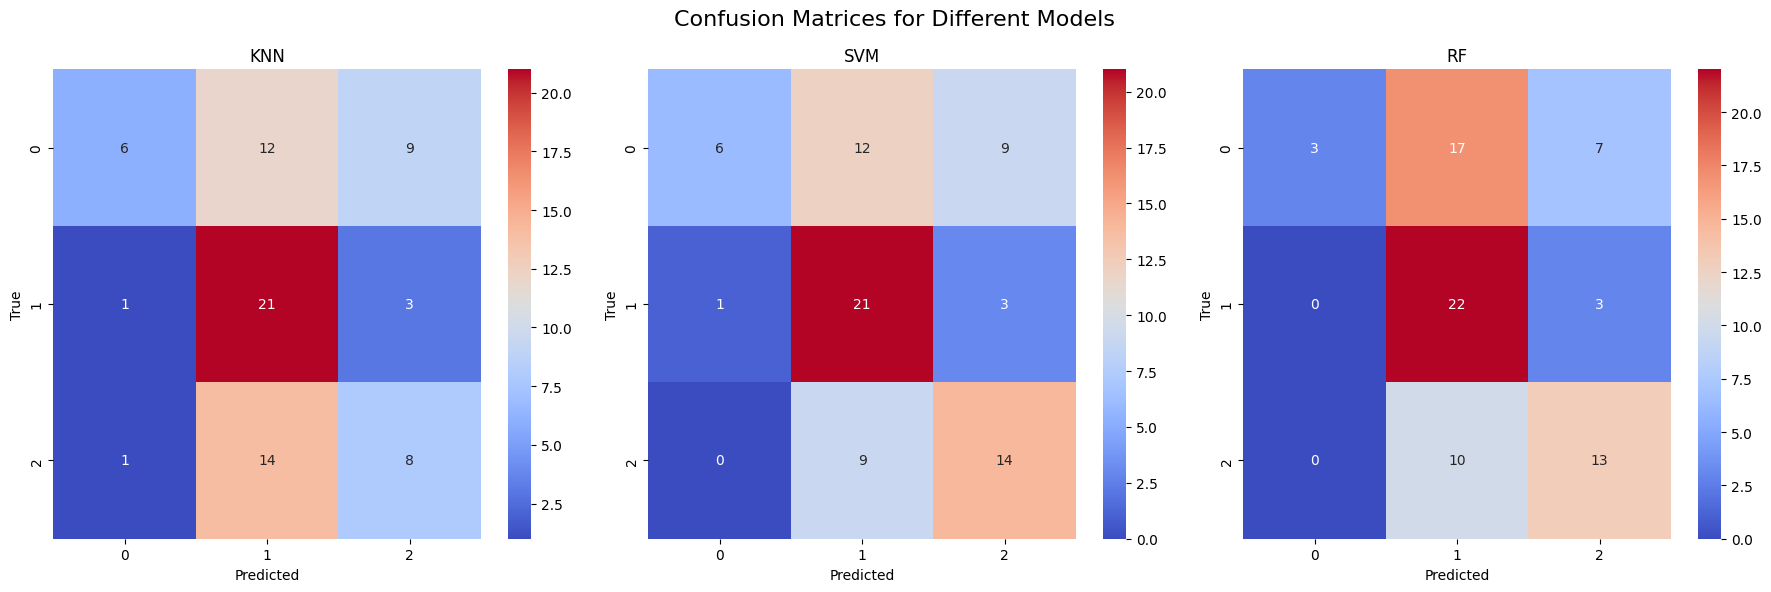

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

knn_conf_matrix = confusion_matrix(y_test, knn_pred)
svm_conf_matrix = confusion_matrix(y_test, svm_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='coolwarm', ax=axes[0])
axes[0].set_title('KNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='coolwarm', ax=axes[1])
axes[1].set_title('SVM')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='coolwarm', ax=axes[2])
axes[2].set_title('RF')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')


plt.tight_layout()
plt.show()